<a href="https://colab.research.google.com/github/ganagalakshmi/FactoryAnalytics/blob/main/MetalVigil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC,Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras.applications import Xception,VGG19,ResNet50,InceptionResNetV2,ResNet152V2,EfficientNetB2,ConvNeXtTiny
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,GlobalMaxPooling2D,Dropout
random.seed(555)

In [ ]:
# Mount Google Drive if your dataset is stored there
from pathlib import Path  # Import the pathlib module

from google.colab import drive
drive.mount('/content/drive')

# Adjust the path accordingly
dir_train = "/content/drive/MyDrive/Casting Dataset/casting_data/casting_data/train"
dir_test = "/content/drive/MyDrive/Casting Dataset/casting_data/casting_data/test"

data_dir_train = Path(dir_train)  # Use Path directly without "pathlib."
data_dir_test = Path(dir_test)


Mounted at /content/drive


In [ ]:
# Train
dir_train_def = dir_train + '/def_front/'
dir_train_ok = dir_train + '/ok_front/'
# Test
dir_test_def = dir_test + '/def_front/'
dir_test_ok = dir_test + '/ok_front/'

In [ ]:
image_files_train_def = os.listdir(dir_train_def)
image_files_train_ok = os.listdir(dir_train_ok)

In [ ]:
from pathlib import Path

# Assuming you have defined the paths to defective and okay image directories
dir_train_def = "/content/drive/MyDrive/Casting Dataset/casting_data/casting_data/train/def_front"
dir_train_ok = "/content/drive/MyDrive/Casting Dataset/casting_data/casting_data/train/ok_front"

# Create Path objects for the directories
data_dir_train_def = Path(dir_train_def)
data_dir_train_ok = Path(dir_train_ok)

# Assuming you have lists of file paths for defective and okay images
image_files_train_def = list(data_dir_train_def.glob('*.jpeg'))
image_files_train_ok = list(data_dir_train_ok.glob('*.jpeg'))

# Calculate the number of images
n = len(image_files_train_def)
m = len(image_files_train_ok)

# Print the results
print(f'The number of all images in the training set is {n + m}')
print(f'Number of defective images is {n}')
print(f'Number of okay images is {m}')

# Calculate and print the ratio
if n > 0:
    ratio_ok_def = m / n
    print(f'The ratio between okay and defective images is {ratio_ok_def:.2f}')
else:
    print('Cannot calculate the ratio because the number of defective images is zero.')


The number of all images in the training set is 6633
Number of defective images is 3758
Number of okay images is 2875
The ratio between okay and defective images is 0.77


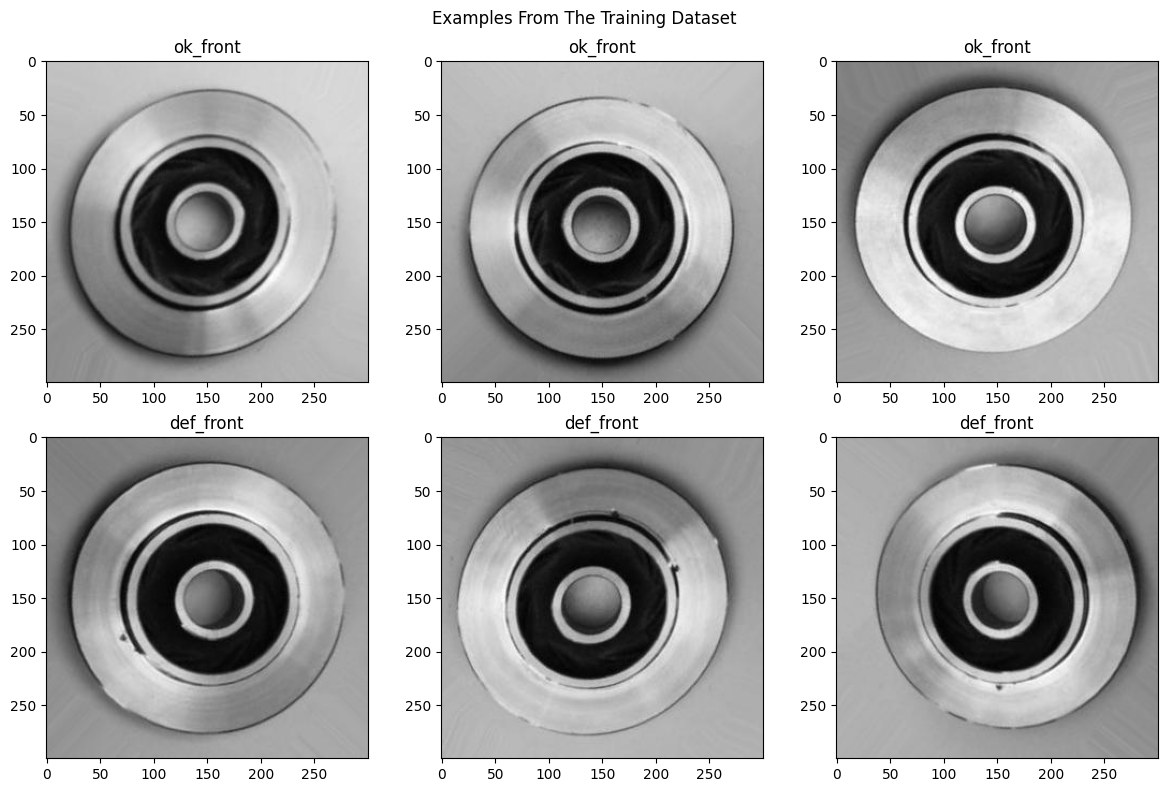

In [ ]:
# Function to get a list of random image files from a directory
def get_random_image_files(directory, num_files):
    files = os.listdir(directory)
    random.shuffle(files)
    return files[:num_files]

# Create a 2x3 grid for "ok_front" images
plt.figure(figsize=(12, 8))
plt.suptitle('Examples From The Training Dataset')

for i in range(3):
    plt.subplot(2, 3, i + 1)
    image_files_ok = get_random_image_files(dir_train_ok, 3)
    img = Image.open(os.path.join(dir_train_ok, image_files_ok[i]))
    plt.imshow(img)
    plt.title('ok_front')

# Create a 2x3 grid for "def_front" images
for i in range(3):
    plt.subplot(2, 3, i + 4)
    image_files_def = get_random_image_files(dir_train_def, 3)
    img = Image.open(os.path.join(dir_train_def, image_files_def[i]))
    plt.imshow(img)
    plt.title('def_front')

plt.tight_layout()
plt.show()

In [ ]:
# same for the ok_front
img = Image.open(os.path.join(dir_train_def, image_files_def[0]))
img.size, img.mode

((300, 300), 'RGB')

In [ ]:
# We can observe that we can generate more examples just using rotations
img_size = (300,300)
rand_seed = 555
batch_size = 32
epochs = 15

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    brightness_range=[0.2, 1.5],
    validation_split=0.4,
)

test_gen = ImageDataGenerator(rescale=1./255)


In [ ]:
arg_train = {'target_size': img_size,
             'color_mode': 'rgb',
             'classes': {'ok_front': 0,
                         'def_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}

arg_test = {'target_size': img_size,
            'color_mode': 'rgb',
            'classes': {'ok_front': 0,
                        'def_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}
# 80%
train_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='training',
                                          **arg_train)
#20%
valid_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='validation',
                                          **arg_train)

# for the 0 and 1 ...etc
test_set = test_gen.flow_from_directory(directory=dir_test,
                                        **arg_test)


Found 3980 images belonging to 2 classes.
Found 2653 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [ ]:
def load_pretrained_model(model_name):
    if model_name == 'Xception':
        return Xception(weights='imagenet', include_top=False)
    elif model_name == 'ResNet50':
        return ResNet50(weights='imagenet', include_top=False)
    elif model_name == 'InceptionResNetV2':
        return InceptionResNetV2(weights='imagenet', include_top=False)
    elif model_name == 'ResNet152V2':
        return ResNet152V2(weights='imagenet', include_top=False)

def create_and_compile_model(base_model, learning_rate=0.01):
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer='l1_l2')(x)
    x = Dense(128, activation='relu', kernel_regularizer='l1_l2')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Changed the number of output neurons and activation

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(lr=learning_rate),
                  loss='binary_crossentropy',  # Changed the loss function
                  metrics=['accuracy', AUC(), Precision(), Recall()])  # Updated metrics

    return model

def train_and_evaluate_model(model, model_name, train_set, valid_set, test_set, epochs=10, batch_size=32):
    model_checkpoint = ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_auc',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )

    # Start the timer
    start_time = time.time()

    history = model.fit(
        train_set,
        steps_per_epoch=train_set.samples // batch_size,
        epochs=epochs,
        validation_data=valid_set,
        validation_steps=valid_set.samples // batch_size,
        callbacks=[model_checkpoint]
    )

    # End the timer
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model on the test set
    test_loss, *test_metrics = model.evaluate(test_set, steps=test_set.samples // batch_size)
    test_acc = test_metrics[0]
    test_auc = test_metrics[1]
    test_precision = test_metrics[2]
    test_recall = test_metrics[3]

    # Start the evaluation timer
    evaluation_time = time.time() - end_time

    # Print the results
    print(f"model: {model_name}")
    print(f"Test accuracy: {test_acc * 100:.2f}%")
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Evaluation time: {evaluation_time:.2f} seconds")

    y_true = test_set.classes
    y_pred = model.predict(test_set)
    y_pred_classes = (y_pred > 0.5).astype(int)  # Convert to 0 or 1 based on a threshold
    cm = confusion_matrix(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes)
    auc = roc_auc_score(y_true, y_pred)

    return test_acc, cm, report, auc, test_precision, test_recall, history.history


In [ ]:
#model_names = ['Xception', 'InceptionResNetV2', 'ResNet152V2']
model_names = ['ResNet152V2']
results = {}

for model_name in model_names:
    print(f"Training model: {model_name}")
    base_model = load_pretrained_model(model_name)
    model = create_and_compile_model(base_model)
    test_acc, cm, report, auc, precision, recall, history = train_and_evaluate_model(model,
                                                         model_name,
                                                         train_set,
                                                         valid_set,
                                                         test_set,
                                                         epochs,
                                                         batch_size)

    results[model_name] = {
        'test_accuracy': test_acc,
        'confusion_matrix': cm,
        'classification_report': report,
        'roc_auc': auc,
        'history': history
    }

Training model: ResNet152V2
234545216/234545216 [==============================] - 2s 0us/step


Epoch 1/15
124/124 [==============================] - ETA: 0s - loss: 49.7574 - accuracy: 0.9043 - auc: 0.9349 - precision: 0.9200 - recall: 0.9101
Epoch 1: val_auc improved from -inf to 0.99412, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 1615s 13s/step - loss: 49.7574 - accuracy: 0.9043 - auc: 0.9349 - precision: 0.9200 - recall: 0.9101 - val_loss: 12.0128 - val_accuracy: 0.8880 - val_auc: 0.9941 - val_precision: 1.0000 - val_recall: 0.8023
Epoch 2/15
124/124 [==============================] - ETA: 0s - loss: 7.4212 - accuracy: 0.9316 - auc: 0.9761 - precision: 0.9440 - recall: 0.9347
Epoch 2: val_auc improved from 0.99412 to 0.99571, saving model to best_model.h5
124/124 [==============================] - 219s 2s/step - loss: 7.4212 - accuracy: 0.9316 - auc: 0.9761 - precision: 0.9440 - recall: 0.9347 - val_loss: 4.6129 - val_accuracy: 0.9768 - val_auc: 0.9957 - val_precision: 0.9850 - val_recall: 0.9738
Epoch 3/15
124/124 [==============================] - ETA: 0s - loss: 3.5577 - accuracy: 0.9526 - auc: 0.9893 - precision: 0.9685 - recall: 0.9473
Epoch 3: val_auc did not improve from 0.99571
124/124 [==============================] - 218s 2s/step - loss: 3.5577 - accuracy: 

Best Model: ResNet152V2
Test Accuracy: 99.15%
Confusion Matrix:
[[259   3]
 [  3 450]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       262
           1       0.99      0.99      0.99       453

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715

ROC AUC: 1.00


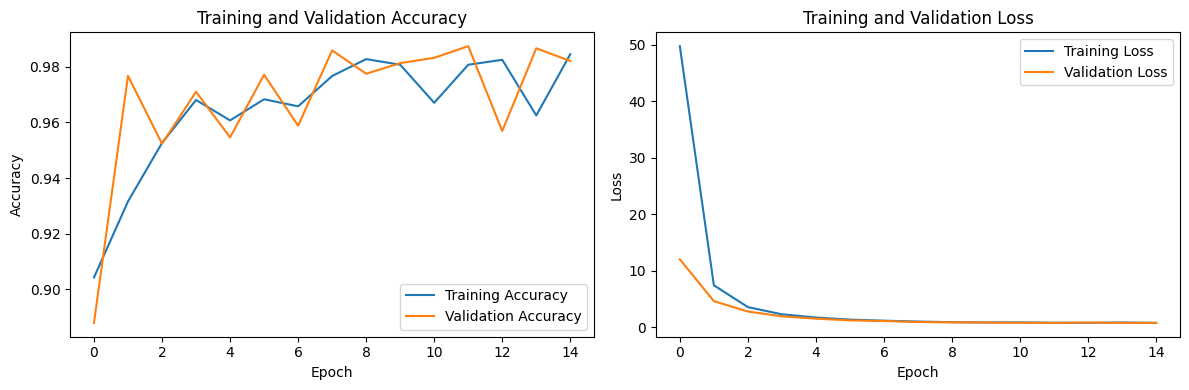

In [ ]:
# Find the model with the highest test auc
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model_results = results[best_model_name]

# Access the performance metrics
best_test_acc = best_model_results['test_accuracy']
best_cm = best_model_results['confusion_matrix']
best_report = best_model_results['classification_report']
best_auc = best_model_results['roc_auc']
best_history = best_model_results['history']

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {best_test_acc * 100:.2f}%")
print("Confusion Matrix:")
print(best_cm)
print("Classification Report:")
print(best_report)
print(f"ROC AUC: {best_auc:.2f}")

# Plot training and validation accuracy and loss

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_history['accuracy'], label='Training Accuracy')
plt.plot(best_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)


Current Working Directory: /content


In [ ]:
# Load the saved model
best_model = load_model("/content/best_model.h5")
# Assuming you have set up the 'test_set' as mentioned earlier
predictions = best_model.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
true_labels = test_set.classes

# Calculate classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
conf_matrix = confusion_matrix(true_labels, predicted_labels)

23/23 [==============================] - 12s 414ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       262
           1       1.00      0.98      0.99       453

    accuracy                           0.99       715
   macro avg       0.98      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



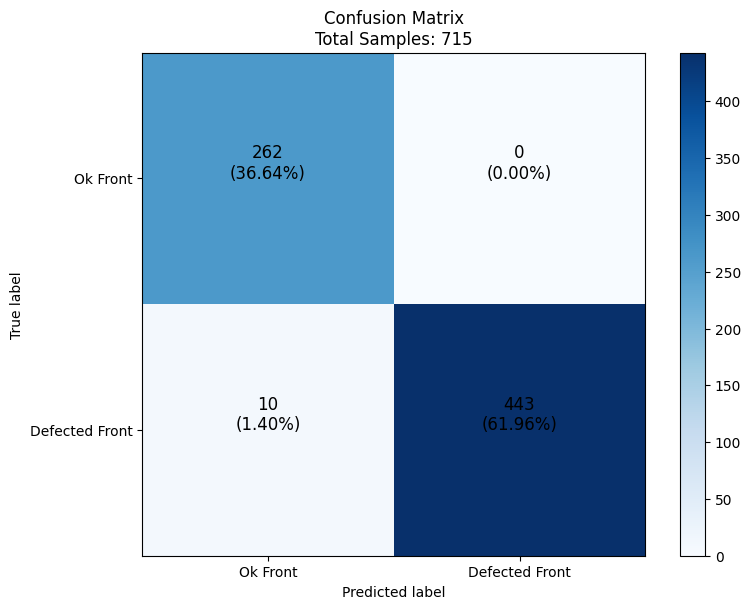

In [ ]:
# Assuming you have 'conf_matrix' calculated as the confusion matrix
total_samples = np.sum(conf_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title(f'Confusion Matrix\nTotal Samples: {total_samples}')
plt.colorbar()
tick_marks = np.arange(2)  # Assuming you have 2 classes (0 and 1)
plt.xticks(tick_marks, ['Ok Front', 'Defected Front'])
plt.yticks(tick_marks, ['Ok Front', 'Defected Front'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add numbers inside the boxes with black color and percentages
for i in range(2):
    for j in range(2):
        count = conf_matrix[i, j]
        percentage = (count / total_samples) * 100
        plt.text(j, i, f'{count}\n({percentage:.2f}%)', horizontalalignment='center', color='black', fontsize=12)

plt.show()

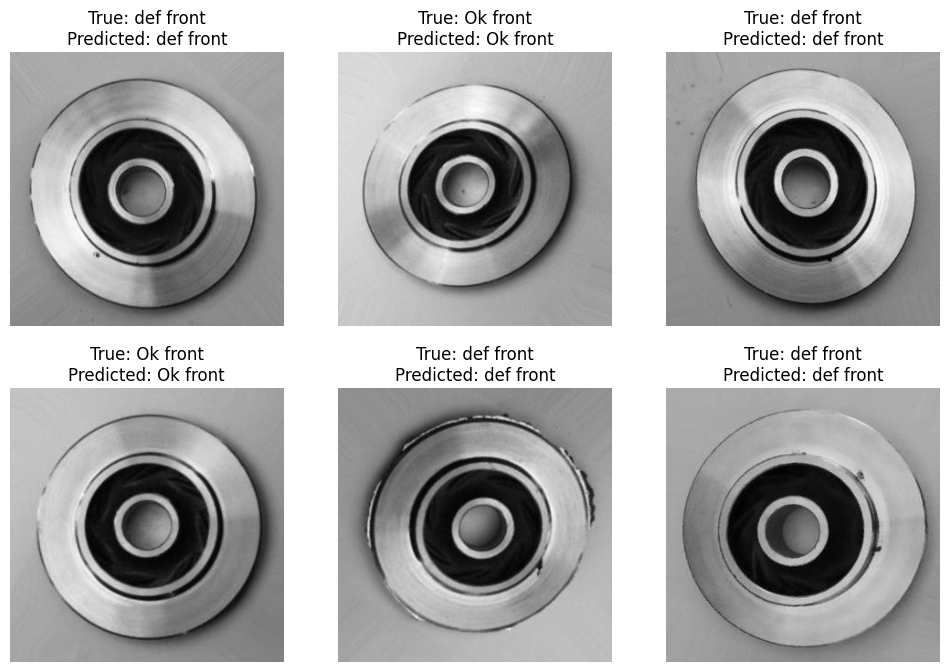

In [ ]:
num_samples_to_display = 6
nbr_samples_every_row = 3
rows = num_samples_to_display // nbr_samples_every_row
random.seed(33)

total_samples = len(test_set.filenames)

# Generate random indices to select random samples
random_indices = random.sample(range(total_samples), num_samples_to_display)

# Initialize a list to store the selected images, true labels, and predicted labels
random_sample_data = []

# Extract the random images, true labels, and predicted labels
for idx in random_indices:
    image_path = test_set.filepaths[idx]
    true_label = test_set.classes[idx]
    image = plt.imread(image_path)
    predicted_label = predicted_labels[idx]
    true_label_text = "def front" if true_label == 1 else "Ok front"
    predicted_label_text = "def front" if predicted_label == 1 else "Ok front"
    random_sample_data.append((image, true_label_text, predicted_label_text))

# Visualize the random sample images with true and predicted labels
plt.figure(figsize=(12, 8))
for i, (image, true_label_text, predicted_label_text) in enumerate(random_sample_data):
    plt.subplot(rows, nbr_samples_every_row, i + 1)
    plt.imshow(image)
    plt.title(f'True: {true_label_text}\nPredicted: {predicted_label_text}')
    plt.axis('off')
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.5281 to fit



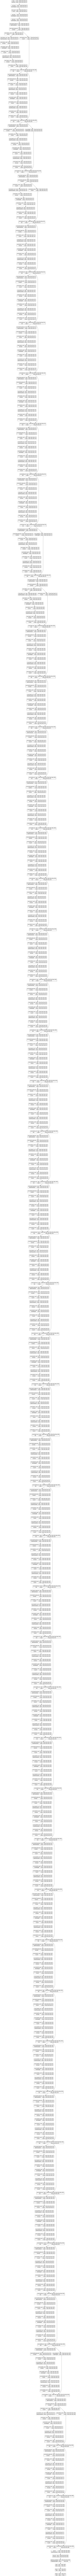

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'best_model' is your trained model
plot_model(best_model, show_shapes=True)


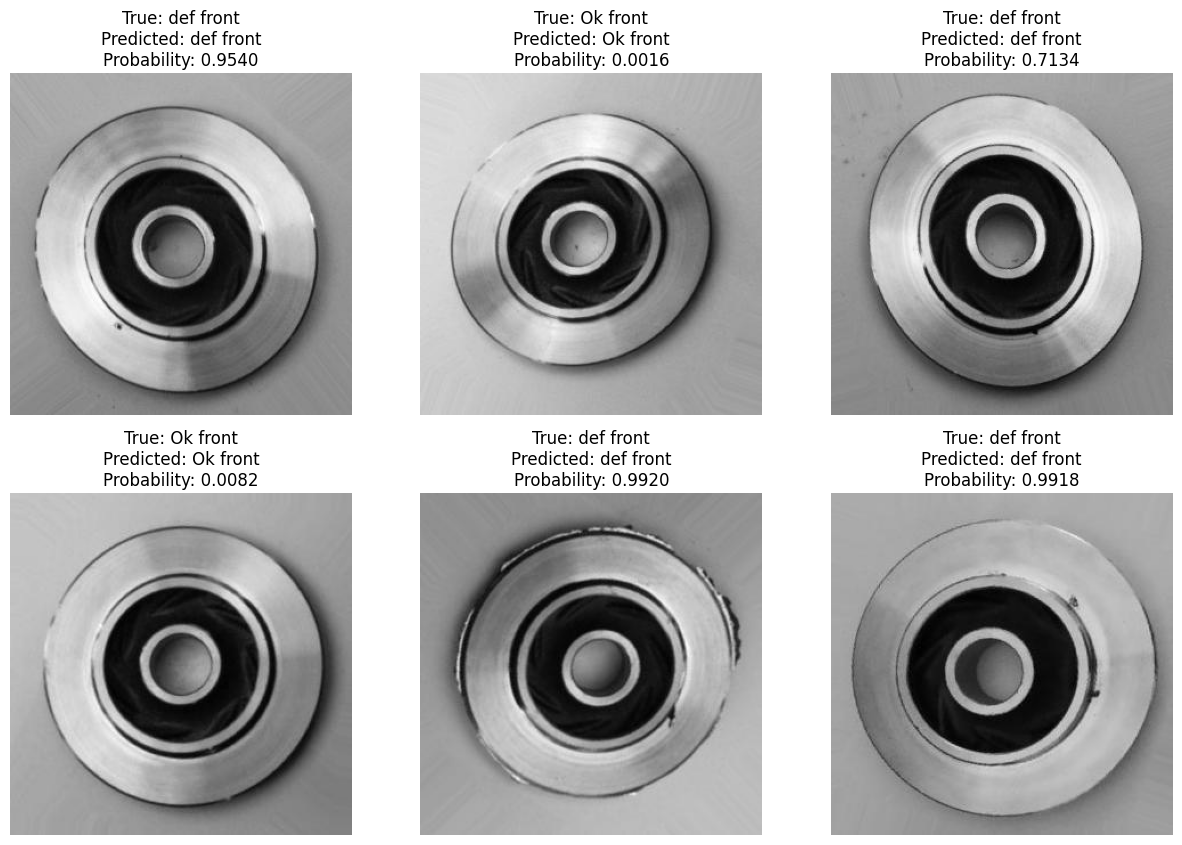

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
num_samples_to_display = 6
nbr_samples_every_row = 3
rows = num_samples_to_display // nbr_samples_every_row
random.seed(33)

total_samples = len(test_set.filenames)

# Generate random indices to select random samples
random_indices = random.sample(range(total_samples), num_samples_to_display)

# Initialize a list to store the selected images, true labels, predicted labels, and probabilities
random_sample_data = []

# Extract the random images, true labels, predicted labels, and probabilities
for idx in random_indices:
    image_path = test_set.filepaths[idx]
    true_label = test_set.classes[idx]
    image = plt.imread(image_path)
    predicted_label = predicted_labels[idx]
    predicted_probability = predictions[idx][0]  # Assuming a binary classification task
    true_label_text = "def front" if true_label == 1 else "Ok front"
    predicted_label_text = "def front" if predicted_label == 1 else "Ok front"
    random_sample_data.append((image, true_label_text, predicted_label_text, predicted_probability))

# Visualize the random sample images with true and predicted labels and probabilities
plt.figure(figsize=(15, 10))
for i, (image, true_label_text, predicted_label_text, predicted_probability) in enumerate(random_sample_data):
    plt.subplot(rows, nbr_samples_every_row, i + 1)
    plt.imshow(image)
    plt.title(f'True: {true_label_text}\nPredicted: {predicted_label_text}\nProbability: {predicted_probability:.4f}')
    plt.axis('off')
plt.show()
